#Analyzing the NYC Subway Dataset

This project consists of two parts. In Part 1 of the project, you should have completed the questions in Problem Sets 2, 3, and 4 in the Introduction to Data Science course.
This document addresses part 2 of the project. Please use this document as a template and answer the following questions to explain your reasoning and conclusion behind your work in the problem sets. You will attach a document with your answers to these questions as part of your final project submission.

## <font color='red'>The Data I used:</font>

<font color='red'>- The improved data provided by : https://www.dropbox.com/s/1lpoeh2w6px4diu/improved-dataset.zip?dl=0
<br/>

Since the data used in Problem Sets in the course "Intro to Data Science" is incomplete, I don't know whether the data subsets chosen by the course is the same at each problem. At first I want to do my analysis in both the original and improved datasets, but the more methods I put in, the more complex my report is, so I finally decide to use only the "Improved data set" provided by the links above to do a complete analysis in this project on my own computer.</font>t

In [26]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

### 0. References

1. Improved data set: https://www.dropbox.com/s/1lpoeh2w6px4diu/improved-dataset.zip?dl=0 
2. Improved data description: https://s3.amazonaws.com/uploads.hipchat.com/23756/665149/05bgLZqSsMycnkg/turnstile-weather-variables.pdf
3. ggplot histogram: http://stackoverflow.com/questions/19377371/how-to-make-a-histogram-in-ipython-notebook-using-ggplot2-for-python
4. Multicollinear Analysis: https://onlinecourses.science.psu.edu/stat501/node/346
5. Residual Analysis: http://docs.statwing.com/interpreting-residual-plots-to-improve-your-regression/#y-unbalanced-header
6. Hide code: http://protips.maxmasnick.com/hide-code-when-sharing-ipython-notebooks

In [1]:
%matplotlib inline

from ggplot import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import warnings
warnings.filterwarnings('ignore')

path = r'~/Documents/GitHub/DataAnalystNanodegree/test/improved-dataset/turnstile_weather_v2.csv'

turnstile_weather = pd.read_csv(path)

enter_rain = turnstile_weather[turnstile_weather.rain == 1]['ENTRIESn_hourly'].reset_index()
enter_not_rain = turnstile_weather[turnstile_weather.rain == 0]['ENTRIESn_hourly'].reset_index()

entries_per_hour = turnstile_weather.groupby('hour').mean().reset_index()
def weight_for_hour(hour):
    return float(entries_per_hour[entries_per_hour.hour == hour]['ENTRIESn_hourly'])

entries_per_weekday = turnstile_weather.groupby('day_week').mean().reset_index()
def weight_for_dayweek(day):
    return float(entries_per_weekday[entries_per_weekday.day_week == day]['ENTRIESn_hourly'])

turnstile_weather['weighted_hour'] = turnstile_weather['hour'].apply(weight_for_hour)
turnstile_weather['weighted_day_week'] = turnstile_weather['day_week'].apply(weight_for_dayweek)


### 1. Statistical Test

#### 1.1 Which statistical test did you use to analyze the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?

1. Mann Whitney U-test
2. two-tail P value 
3. null hypothesis : 
        let X be the population of the number of riderships on raining days
        let Y be the population of the number of riderships on non-raining days
        given random draws x from population X and y from population Y
        P(x > y) = 0.5 
4. p-critical : 0.05

#### 1.2 Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

Since the distribution for riderships is not a normal distribution, I can't use normal T-test to analyze the data, so I need to use non-paramatric tests, that is, the Mann Whitney U-test.

#### 1.3 What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.

1. mean of riderships on rainy day: 2028.20
2. mean of riderships on non-rainy day: 1845.54
3. p-value = 2.74e-06

#### 1.4 What is the significance and interpretation of these results?

2.74e-06*2 = 5.48e-06 < 0.05, The result is significance, I reject the Null Hypothesis

### 2. Linear Regression 

#### 2.1. What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model:

B. Gradient descent using Scikit Learn

#### 2.2 What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?

'rain', 'weighted_hour', 'weighted_day_week' and 'UNIT' as dummy variable <br/>
(I will explain what 'weighted_hour' and 'weighted_day_week' are in question 2.3)

#### 2.3 Why did you select these features in your model? We are looking for specific reasons that lead you to believe that

1. I don't think fog, wind and pressure will affect people's intention to ride subway or not much, I try to put them into my model and the result of the R^2 didn't change more than 0.001 ,so I drop them out of my model. 

2. I want to use the thunder feature, but the value is zero for all the data, so scipy didn't allow me to put it into features ( and would be useless if it can) .

3. I want to use precipi and meantempi as a feature in the first place, but they are highly correlated with 'rain' (0.331453 and -0.321441 as shown below) and may cause multicollinear problem to my model, so I drop them out from my featrues cause I want to know the pure effect of 'rain'.

4. I put 'UNIT' as dummy variable because my R^2 value is hugely imporved by it.

5. I think time is a very important feature, since must people will take subway regularly at particular days and time, so I use 'hour' and create a column called 'day_week' from 'DATEn' to see which day it is in a week. Moreover, I try to give each 'day' and 'hour' a value so they will be monotonic with riderships since it make more sence in a linear regression model. I did this by create two new columns named 'weighted_hour' and 'weighted_day_week' and put the mean of the riderships in each 'hour' and 'day' to these columns, after doing this, my R^2 value grows from 0.46 to 0.53.

#### Correlation between each of my features :

In [2]:
print(turnstile_weather[['rain','weighted_hour','weighted_day_week','precipi','meantempi']].corr())

                       rain  weighted_hour  weighted_day_week   precipi  \
rain               1.000000      -0.002859           0.128729  0.331453   
weighted_hour     -0.002859       1.000000          -0.009227 -0.107943   
weighted_day_week  0.128729      -0.009227           1.000000  0.078720   
precipi            0.331453      -0.107943           0.078720  1.000000   
meantempi         -0.321441       0.000682          -0.005590 -0.144916   

                   meantempi  
rain               -0.321441  
weighted_hour       0.000682  
weighted_day_week  -0.005590  
precipi            -0.144916  
meantempi           1.000000  


#### 2.4 What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?

1. rain: 26.360
2. weighted_hour: 1.040
3. weighted_day_week: 1.008

#### 2.5 What is your model’s R2 (coefficients of determination) value

0.53

#### 2.6 What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?

1. This means the data is not very close to the regression line, the prediction power of this model is poor. 
2. No! First of all, the R^2 is less than 0.6, that means it can only explain less than 0.6 variability of the response data around its mean. Second, I plot the "residual plot" below and it shows that the residual distribution is not random, which means that linear model is not an appropriate model to predict ridership. I did some further analysis in question 5 to deal with this problem.

![](http://i.imgur.com/dqdKIhW.png)

### 3. Visualization

#### 3.1 One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.

The result shows that the quantity of data recoreded on a non-raining days is way more than the one on a raining days, and the data distribution for ridership is highly left skewed for both non-raining and raining days.

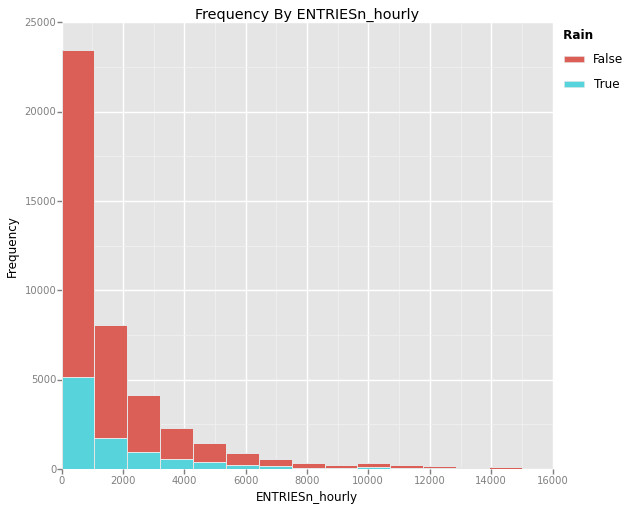

<ggplot: (-9223372036574714771)>

In [20]:
enter_rain = enter_rain[enter_rain.ENTRIESn_hourly < 20000]
df = turnstile_weather[['rain','ENTRIESn_hourly']]
df = df[df.ENTRIESn_hourly < 15000]
df['rain'] = df['rain'] == 1

p = ggplot(aes(x='ENTRIESn_hourly',fill='rain'), data=df) + ggtitle( 'Frequency By ENTRIESn_hourly' ) + xlab('ENTRIESn_hourly') + ylab('Frequency')
p + geom_histogram(binwidth=1000)

#### 3.2 One visualization can be more freeform. You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. 

1. I draw a picture describe the relation bewteen 'ENTRIESn_hourly' and 'hour', it shows that most of the people enter subway at 12 and 20 o'clock. 

2. I draw a picture describe the relation bewteen 'day_week' and 'hour'(where day_week is the day in each week, 0 means sunday and 6 means saturday), it shows that few people ride subway at weekends. 

3. Since the number of ridership is drastically different in each timespan and each day in week, I think 'hour' and 'day_week' are both important values that should be used in my regression model. However, they are not monotonic with 'ENTRIESn_hourly', so I did some transform as described in question 2.3 before I use them.

4. I want to see whether the two features that I created, 'weighted_hour' and 'weighted_day_week', have any relation with 'rain', so I draw two more plots with 'weighted_hour' and 'weighted_day_week' on the x-axis and 'rain' on the y-axis. The result shows that the 'rain' hardly have any relation with 'weighted_hour' and have only little relation with 'weighted_day_week', which support the values in the correlation table that I shown in question 2.3 above. So, I can keep them in my model without worrying about the multicollinear problem will affect the weight value of my 'rain' feature.

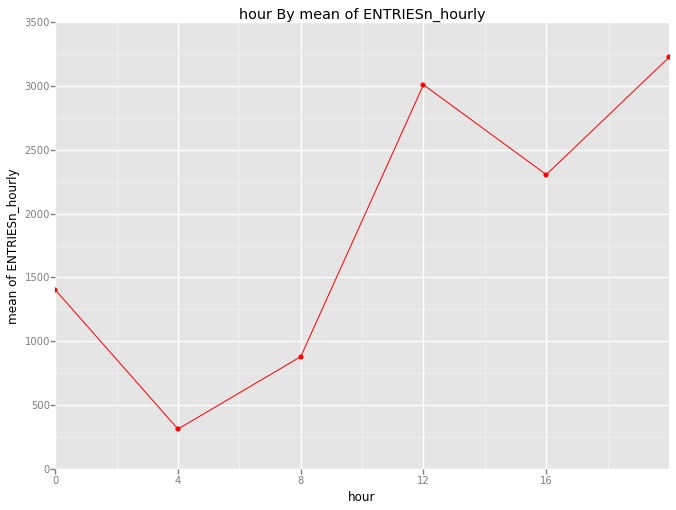

<ggplot: (280118697)>


In [11]:
entries_per_hour = turnstile_weather.groupby('hour').mean().reset_index()
p = ggplot( entries_per_hour, aes( 'hour', 'ENTRIESn_hourly') ) + scale_x_continuous(breaks=range(0,20,4)) + xlim(0,20) + ggtitle( 'hour By mean of ENTRIESn_hourly' ) + ylab('mean of ENTRIESn_hourly') + geom_point( color = "red" ) + geom_line( color = "red")
print(p)

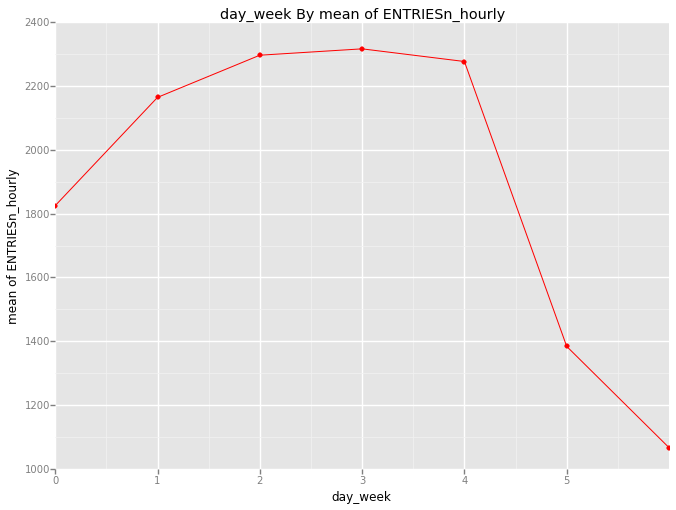

<ggplot: (-9223372036575280668)>


In [8]:
turnstile_weather['day_week'] = pd.to_datetime(turnstile_weather['DATEn']).dt.weekday
entries_per_weekday = turnstile_weather.groupby('day_week').mean().reset_index()
p = ggplot( entries_per_weekday, aes( 'day_week', 'ENTRIESn_hourly') ) + scale_x_continuous(breaks=range(0,6,1)) + xlim(0,6) + ggtitle( 'day_week By mean of ENTRIESn_hourly' ) + ylab('mean of ENTRIESn_hourly') + geom_point( color = "red" ) + geom_line( color = "red")
print(p)

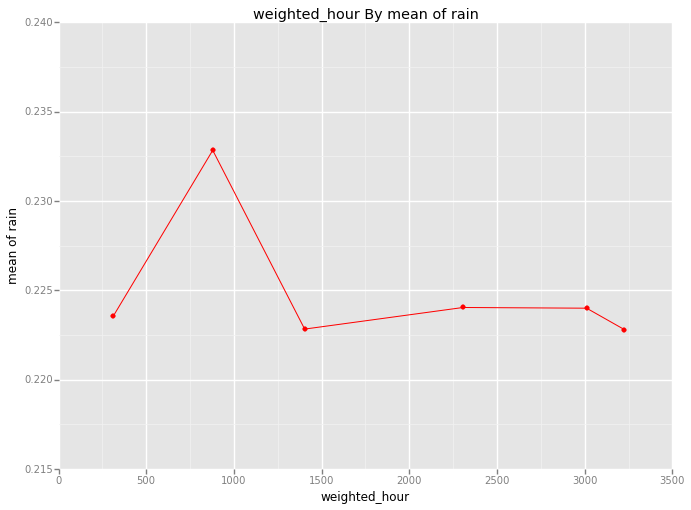

<ggplot: (-9223372036573189744)>


In [33]:
p = ggplot( entries_per_hour, aes( 'weighted_hour', 'rain') ) + ggtitle( 'weighted_hour By mean of rain' ) + ylab('mean of rain') + geom_point( color = "red" ) + geom_line( color = "red")
print(p)

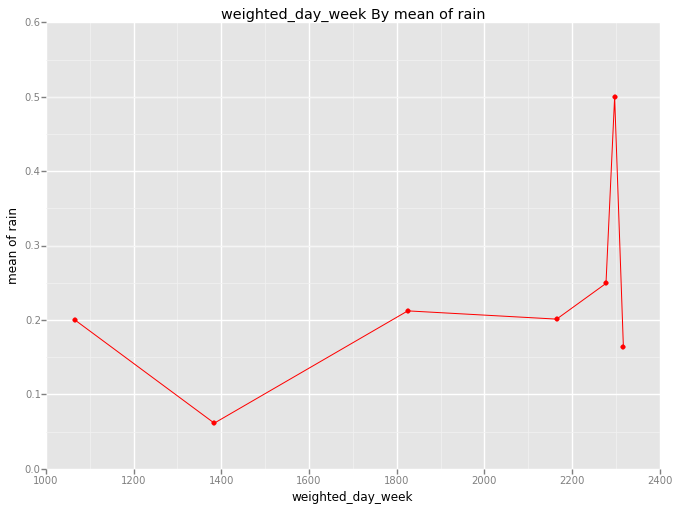

<ggplot: (279977743)>


In [34]:
p = ggplot( entries_per_weekday, aes( 'weighted_day_week', 'rain') ) + ggtitle( 'weighted_day_week By mean of rain' ) + ylab('mean of rain') + geom_point( color = "red" ) + geom_line( color = "red")
print(p)

### 4.Conclusion

#### 4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?  

#### 4.2 What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.

1. From the result of Mann Whitney U-test, the result is very significant and the mean of riderships on rainy day is larger than the mean of riderships on non-rainy day, so it shows that there are more people ride subway on rainy days 

2. From the result of my regression test, since I already make sure those features I use didn't have strong corretion with each other, the weight of the feature 'rain' is positive means that the rain have positive effect on the number of riderships. 

3. According to the two results shows above, My conclusion is that more people will ride subway when it is a raining day.

### 5. Reflection

#### 5.1 Please discuss potential shortcomings of the methods of your analysis, including:

By the plot of residual in question 2.6 I find out:

1. There are too many zeros in my data, but I don't know whether it's a good way to remove all the zeros from my model, maybe the result can be improved if I can clean off more useless data.

2. The shape of the residual plot shows that the data have 'Heteroscedasticity' problem, that is, the residuals get larger as the prediction moves from small to large, so if I want to get a more power prediction model, I need to transform my 'ENTRIESn_hourly' data. Actually, I tried using log( value of 'ENTRIESn_hourly' + 1) as the ridership instead of the original one and I plot the new diagram below, it looks more like a bell-shaped distribution and the R^2 can grow to <font color="red">0.67</font> by using this new data to represent ridership.

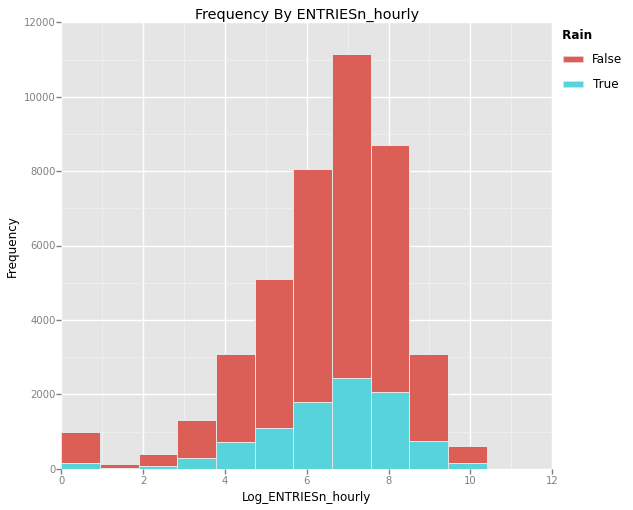

<ggplot: (-9223372036574948341)>

In [24]:
enter_rain = enter_rain[enter_rain.ENTRIESn_hourly < 20000]
df = turnstile_weather[['rain','ENTRIESn_hourly']]
df['ENTRIESn_hourly'] = np.log(df['ENTRIESn_hourly']+1)
df['rain'] = df['rain'] == 1

p = ggplot(aes(x='ENTRIESn_hourly',fill='rain'), data=df) + ggtitle( 'Frequency By ENTRIESn_hourly' ) + xlab('Log_ENTRIESn_hourly') + ylab('Frequency')
p + geom_histogram(binwidth=1)

#### 5.2 (Optional) Do you have any other insight about the dataset that you would like to share with us?

I try to randomly split ten percent of data as testing data and use the other as training data, and calculate the R^2 value by the testing data and the model generated by the training data, the resulted R^2 value is 0.51, which doesn't change too much from the original 0.53, So I think my model didn't overfit.